In [1]:
import pandas as pd
import os
import numpy as np
import re
from openpyxl import load_workbook

### generate summary table for lead snp start from here

In [2]:
def fuma(fp):
    IndSigSNPs = pd.read_csv(fp+'IndSigSNPs.txt',header=0,sep='\t')
    snp = pd.read_csv(fp+'snps.txt',header=0,sep='\t')

    IndSigSNPs = IndSigSNPs[['uniqID','nSNPs','nGWASSNPs','rsID','pos','chr','p','GenomicLocus']]
    ls = IndSigSNPs['uniqID'].values
    if 'beta' not in snp.columns:
        print('ssssss')
        snp['beta']=''
    snp = snp[['uniqID','non_effect_allele','effect_allele','MAF','beta','nearestGene','func','dist','CADD','RDB']]
    snp = snp[snp['uniqID'].isin(ls)]

    df = snp.merge(IndSigSNPs,on='uniqID')
    df = df.rename(columns={"func": "annot", "nearestGene": "symbol",'non_effect_allele':'A2','effect_allele':'A1'})
    return df

In [3]:
### beside hmagma output, you need gene_name files to run below code, cause there is no gene name in hmagma result!
def hmagma(df,ls):
    name_fp = ['Astro_gene_name.csv','Fetal_brain_gene_name.csv','Adult_brain_gene_name.csv','neuro_gene_name.csv']
    cls=['sigHMAGMA_Astro','sigHMAGMA_Fetal_brain','sigHMAGMA_Adult_brain','sigHMAGMA_neuro']
    for i in range(len(ls)):
        h=ls[i]
        name=pd.read_csv(name_fp[i],usecols=['GENE','Gene.name'])
        if 'Gene.name' not in h.columns:
            h = h.merge(name,on='GENE',how='left')[['P','Gene.name']]
        else:
            h=h[['P','Gene.name']]
        if h.shape[0] > 300:
            h['bon'] = (h['P'] < 0.05/h.shape[0])
        else:
            h['bon']=True
        df = df.merge(h,how='left',left_on='Nearest gene',right_on='Gene.name')
        df[cls[i]]=df['bon'].apply(lambda x: 1 if x else 0)
        df=df.drop(['P','Gene.name','bon'],axis=1)
    df['sigHMAGMA'] = df[cls[0]] | df[cls[1]] | df[cls[2]] | df[cls[3]]
    df=df.drop(cls,axis=1)

    return df

In [14]:
def lead_snp(fuma_fp,magma_fp,spred_fp,ls):
    df=fuma(fuma_fp)
    #fp = os.path.join('fuma','gSEM-AUDIT.xlsx')
    #gwas = pd.read_excel(fp, 'common-factor-GWAS-catalog')
    magma = pd.read_csv(magma_fp,sep='\s+')
    spred = pd.read_csv(spred_fp,sep='\s+')
    

    size = magma.shape[0]
    #sigMAGMA
    magma=magma[['P','SYMBOL']]
    df['sigMAGMA']  = df['symbol'].isin(magma['SYMBOL']).apply(lambda x: 1 if x else 0)
    temp = df[['sigMAGMA','symbol']]
    tls= df[df['symbol'].isin(magma['SYMBOL'])]['symbol']
    p = magma[magma['SYMBOL'].isin(tls)][['P','SYMBOL']]
    temp['p']=temp.apply(lambda x : np.nan if x['sigMAGMA']==0 else p[p['SYMBOL']==x['symbol']]['P'].values[0],axis=1)
    df['sigMAGMA'] = [i&t for i, t in zip(temp['sigMAGMA']==1,temp['p']<0.05/size)]
    df['sigMAGMA'] = df['sigMAGMA'] .apply(lambda x: 1 if x else 0)
    
    #sigSPrediXcan
    size = spred.shape[0]

    df['sigSPrediXcan']  = df['symbol'].isin(spred['gene_name']).apply(lambda x: 1 if x else 0)
    temp = df[['sigSPrediXcan','symbol']]
    tls= df[df['symbol'].isin(spred['gene_name'])]['symbol']
    p = spred[spred['gene_name'].isin(tls)][['pvalue','gene_name']]
    temp['p']=temp.apply(lambda x : np.nan if x['sigSPrediXcan']==0 else p[p['gene_name']==x['symbol']]['pvalue'].values[0],axis=1)
    temp['sigSPrediXcan'] = [i&t for i, t in zip(temp['sigSPrediXcan']==1,temp['p']<0.05/size)]
    df['sigSPrediXcan'] = temp['sigSPrediXcan'] .apply(lambda x: 1 if x else 0)
    df = df.rename(columns={"symbol": "Nearest gene"})
    
    #sigHMAGMA
    df=hmagma(df,ls)
    
    df['Evidence'] = df['sigMAGMA'] + df['sigSPrediXcan']+ df['sigHMAGMA']
    df=df[['GenomicLocus','rsID','chr','pos','A1','A2','MAF','p','beta','Nearest gene','dist','annot','CADD','RDB','sigMAGMA','sigSPrediXcan','sigHMAGMA','Evidence','nSNPs','nGWASSNPs']]
    df= df.fillna('NA')
    df = df.rename(columns={"symbol": "Nearest gene"})
    return df
    

### please input your folder/file name below!

In [16]:
#folder name for fuma files,(which should contain IndSigSNPs.txt and snps.txt )
fuma_fp = 'data/Lead-SNPs/alcohol-common/'
#file name for magma result/ magma file need to have columns('SYMBOL','P'), also cannot be csv file
magma_fp = 'data/MAGMA/alcohol-common/magma.genes.out.ALCPcommon.txt'
#file name for smultiXcan result
spred_fp = 'data/S-PrediXcan/externalizing-alcohol-common/SMultiXcan_Brain_v8_EXT_MA_Problematic_drinking.csv'
#folder name for hmagma result
fp1 = 'data/H-MAGMA/Alcohol-common/'

#please fill in file name for hmagma result seperately 
h1_astro = pd.read_csv(fp1+'EXT_MA_Problematic_drinking_Astro_HMAGMA.genes.out.txt',sep='\s+')
h1_fetal = pd.read_csv(fp1+'EXT_MA_Problematic_drinking_Fetal_brain_HMAGMA.genes.out.txt',sep='\s+')
h1_adult= pd.read_csv(fp1+'EXT_MA_Problematic_drinking_Adult_brain_HMAGMA.genes.out.txt',sep='\s+')
h1_neuro = pd.read_csv(fp1+'EXT_MA_Problematic_drinking_neuro_HMAGMA.genes.out.txt',sep='\s+')

ls=[h1_astro,h1_fetal,h1_adult,h1_neuro]

df=lead_snp(fuma_fp,magma_fp,spred_fp,ls)
#warning message is normal, you can ignore that

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [17]:
#name of your output file
output_fp='Alcohol-common-summary-table.csv'
df.to_csv(output_fp,index=False)

### repeated step for other project/files

In [210]:
output_fp='Alcohol-Residual-summary-table.csv'
df.to_csv(output_fp,index=False)

In [209]:
#folder name for fuma files,(which should contain IndSigSNPs.txt and snps.txt )
fuma_fp = 'data/Lead-SNPs/alcohol-residual/'
#file name for magma result
magma_fp = 'data/MAGMA/alcohol-residual/FINAL.EXT_COMMON_FACTOR.ALCOHOL_PROB_RES.20191014.PREPARED-MAGMA.txt'
#file name for smultiXcan result
spred_fp = 'data/S-PrediXcan/externalizing-alcohol-residual/SMultiXcan_Brain_v8_FINAL.EXT_COMMON_FACTOR.ALCOHOL_PROB_RES.20191014.csv'
#folder name for hmagma result
fp1 = 'data/H-MAGMA/Alcohol-Residual/'

#please fill in file name for hmagma result seperately 
h1_astro = pd.read_csv(fp1+'ALCP_Res_Adult_brain_HMAGMA.sig.genes.out.csv')
h1_fetal = pd.read_csv(fp1+'ALCP_Res_Astro_HMAGMA.sig.genes.out.csv')
h1_adult= pd.read_csv(fp1+'ALCP_Res_Fetal_brain_HMAGMA.sig.genes.out.csv')
h1_neuro = pd.read_csv(fp1+'ALCP_Res_neuro_HMAGMA.sig.genes.out.csv')

ls=[h1_astro,h1_fetal,h1_adult,h1_neuro]

df=lead_snp(fuma_fp,magma_fp,spred_fp,ls)
#warning message is normal, you can ignore that

ssssss


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [211]:
#folder name for fuma files,(which should contain IndSigSNPs.txt and snps.txt )
fuma_fp = 'data/Lead-SNPs/alcohol-residual-truncated/'
#file name for magma result/ magma file need to have columns('SYMBOL','P'), also cannot be csv file
magma_fp = 'data/MAGMA/alcohol-residual-truncated/magma.genes.out.alc.res.truncated.txt'
#file name for smultiXcan result
spred_fp = 'data/S-PrediXcan/externalizing-alcohol-residual-truncated/SMultiXcan_Brain_v8_EXTERNALIZING_MA_Problematic_drinking_TRUNCATED.csv'
#folder name for hmagma result
fp1 = 'data/H-MAGMA/Alcohol-residual-truncated/'

#please fill in file name for hmagma result seperately 
h1_astro = pd.read_csv(fp1+'Name_added_EXTERNALIZING_MA_Problematic_drinking_TRUNCATED_Astro_HMAGMA.sig.genes.out.csv')
h1_fetal = pd.read_csv(fp1+'Name_added_EXTERNALIZING_MA_Problematic_drinking_TRUNCATED_Fetal_brain_HMAGMA.sig.genes.out.csv')
h1_adult= pd.read_csv(fp1+'Name_added_EXTERNALIZING_MA_Problematic_drinking_TRUNCATED_Adult_brain_HMAGMA.sig.genes.out.csv')
h1_neuro = pd.read_csv(fp1+'Name_added_EXTERNALIZING_MA_Problematic_drinking_TRUNCATED_neuro_HMAGMA.sig.genes.out.csv')

ls=[h1_astro,h1_fetal,h1_adult,h1_neuro]

df=lead_snp(fuma_fp,magma_fp,spred_fp,ls)
#warning message is normal, you can ignore that

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [212]:
#name of your output file
output_fp='Alcohol-residual-truncated-summary-table.csv'
df.to_csv(output_fp,index=False)

### ignore below is no heritability information needed

In [209]:
#folder name for fuma files,(which should contain IndSigSNPs.txt and snps.txt )
fuma_fp = 'data/Lead-SNPs/alcohol-residual/'
#file name for magma result
magma_fp = 'data/MAGMA/alcohol-residual/FINAL.EXT_COMMON_FACTOR.ALCOHOL_PROB_RES.20191014.PREPARED-MAGMA.txt'
#file name for smultiXcan result
spred_fp = 'data/S-PrediXcan/externalizing-alcohol-residual/SMultiXcan_Brain_v8_FINAL.EXT_COMMON_FACTOR.ALCOHOL_PROB_RES.20191014.csv'
#folder name for hmagma result
fp1 = 'data/H-MAGMA/Alcohol-Residual/'

#please fill in file name for hmagma result seperately 
h1_astro = pd.read_csv(fp1+'ALCP_Res_Adult_brain_HMAGMA.sig.genes.out.csv')
h1_fetal = pd.read_csv(fp1+'ALCP_Res_Astro_HMAGMA.sig.genes.out.csv')
h1_adult= pd.read_csv(fp1+'ALCP_Res_Fetal_brain_HMAGMA.sig.genes.out.csv')
h1_neuro = pd.read_csv(fp1+'ALCP_Res_neuro_HMAGMA.sig.genes.out.csv')

ls=[h1_astro,h1_fetal,h1_adult,h1_neuro]

df=lead_snp(fuma_fp,magma_fp,spred_fp,ls)
#warning message is normal, you can ignore that

ssssss


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [209]:
#folder name for fuma files,(which should contain IndSigSNPs.txt and snps.txt )
fuma_fp = 'data/Lead-SNPs/alcohol-residual/'
#file name for magma result
magma_fp = 'data/MAGMA/alcohol-residual/FINAL.EXT_COMMON_FACTOR.ALCOHOL_PROB_RES.20191014.PREPARED-MAGMA.txt'
#file name for smultiXcan result
spred_fp = 'data/S-PrediXcan/externalizing-alcohol-residual/SMultiXcan_Brain_v8_FINAL.EXT_COMMON_FACTOR.ALCOHOL_PROB_RES.20191014.csv'
#folder name for hmagma result
fp1 = 'data/H-MAGMA/Alcohol-Residual/'

#please fill in file name for hmagma result seperately 
h1_astro = pd.read_csv(fp1+'ALCP_Res_Adult_brain_HMAGMA.sig.genes.out.csv')
h1_fetal = pd.read_csv(fp1+'ALCP_Res_Astro_HMAGMA.sig.genes.out.csv')
h1_adult= pd.read_csv(fp1+'ALCP_Res_Fetal_brain_HMAGMA.sig.genes.out.csv')
h1_neuro = pd.read_csv(fp1+'ALCP_Res_neuro_HMAGMA.sig.genes.out.csv')

ls=[h1_astro,h1_fetal,h1_adult,h1_neuro]

df=lead_snp(fuma_fp,magma_fp,spred_fp,ls)
#warning message is normal, you can ignore that

ssssss


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

### heritability methods

In [27]:
trait = []
SNPs_used = []
Mean_chi2 = []
Lambda_GC = []
H2 = []
SE = []
Intercept = []
Intercept_SE = []

In [28]:
def extract_heritability(fp,name):
    f=open(fp)
    lines=f.readlines()

    lines = lines[-9:-2]
    snp = re.findall(r'(?<=LD, ).*(?= SNP)',lines[0])[0]
    mean_chi = re.findall(r'(?<=: ).*(?=\s)',lines[4])[0]
    gc = re.findall(r'(?<=: ).*(?=\s)',lines[3])[0]
    h2 = re.findall(r'(?<=: ).*(?= \()',lines[2])[0]
    se = re.findall(r'(?<=\().*(?=\))',lines[2])[0]
    intercept = re.findall(r'(?<=: ).*(?= \()',lines[-2])[0]
    intercept_se = re.findall(r'(?<=\().*(?=\))',lines[-2])[0]
    print(snp, mean_chi,gc,h2,se,intercept,intercept_se)

    trait.append(name)
    SNPs_used.append(snp)
    Mean_chi2.append(mean_chi)
    Lambda_GC.append(gc)
    H2.append(h2)
    SE.append(se)
    Intercept.append(intercept)
    Intercept_SE.append(intercept_se)

In [29]:
for i in range(10):
    fp = os.path.join('data','MA_AUDIT_%s_2020_03_25.tbl.log' % (i+1))
    extract_heritability(fp,'MA_AUDIT_%s' % (i+1))

1154260 1.2732 1.2332 0.0833 0.0048 1.0094 0.0081
1154260 1.1562 1.1428 0.0488 0.004 1.006 0.0078
1154260 1.1888 1.1651 0.0588 0.0039 1.0074 0.0067
1154260 1.062 1.0588 0.0172 0.0028 1.0084 0.006
1154260 1.0393 1.0405 0.0112 0.0028 1.0042 0.0055
1154260 1.0059 1.0075 0.0035 0.0028 0.9946 0.0059
1154260 1.0906 1.0802 0.0251 0.0034 1.0125 0.0071
1154260 1.0811 1.071 0.0265 0.0033 0.9985 0.0063
1154260 1.0345 1.0345 0.0089 0.0031 1.0065 0.0061
1154260 1.0921 1.0802 0.0271 0.0031 1.0066 0.0067


In [30]:
fp = os.path.join('data','PREPARED.AUDIT_COMMON_FACTOR.20200325.txt.log')
extract_heritability(fp,'COMMON_FACTOR')

1104265 1.1936 1.1523 0.0547 0.0035 0.9889 0.0074


In [31]:
fp = os.path.join('data','PREPARED.AUDIT_CORRELATED_FACTORS_FIRST_FACTOR.20200325.txt.log')
extract_heritability(fp,'FIRST_FACTOR')

1111683 1.2243 1.1908 0.0664 0.0042 0.995 0.0076


In [32]:
fp = os.path.join('data','PREPARED.AUDIT_CORRELATED_FACTORS_SECOND_FACTOR.20200325.txt.log')
extract_heritability(fp,'SECOND_FACTOR')

1111683 1.1009 1.0926 0.0179 0.0018 0.9835 0.007


In [33]:
fp = os.path.join('data','MA_AUDIT_C_2020_03_25.tbl.log')
extract_heritability(fp,'MA_AUDIT_C')
fp = os.path.join('data','MA_AUDIT_P_2020_03_25.tbl.log')
extract_heritability(fp,'MA_AUDIT_P')
fp = os.path.join('data','MA_AUDIT_Total_2020_03_25.tbl.log')
extract_heritability(fp,'MA_AUDIT_Total')

1154260 1.2466 1.2136 0.0776 0.0047 1.0072 0.0076
1154260 1.1898 1.1715 0.0561 0.0039 1.0162 0.007
1154260 1.2778 1.2332 0.0858 0.0049 1.0136 0.0076


In [44]:
df = pd.DataFrame({'trait':trait,'SNPs_used':SNPs_used,'Mean_chi^2':Mean_chi2,'Lambda GC': Lambda_GC, 'h2':H2,'SE':SE,'Intercept':Intercept,'Intercept_SE':Intercept_SE})

In [48]:
df.to_csv('heritability-AUDIT.csv',index=False)


VENN DIAGRAM

In [1]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

In [160]:
eur = pd.read_excel('PheWAS_only_sig.xlsx', 'PheWAS_EUR_rs1229984')
rs45 = pd.read_excel('PheWAS_only_sig.xlsx', 'rs3114045')
rs44 = pd.read_excel('PheWAS_only_sig.xlsx', 'rs116203444')

In [161]:
bon = 0.05/eur.shape[0]
eur_sig = eur[eur['pvalue'] < bon]
bon = 0.05/rs45.shape[0]
rs45_sig = rs45[rs45['pvalue'] < bon]
bon = 0.05/rs44.shape[0]
rs44_sig = rs44[rs44['pvalue'] < bon]

In [162]:
eur_rs45 = eur_sig[eur_sig['phenotype'].isin(rs45_sig['phenotype'])]
eur_rs44 = eur_sig[eur_sig['phenotype'].isin(rs44_sig['phenotype'])]
rs45_rs44 = rs45_sig[rs45_sig['phenotype'].isin(rs44_sig['phenotype'])]
rs44 = rs44_sig[~rs44_sig['phenotype'].isin(eur_sig['phenotype'])]
eur= eur_sig[~eur_sig['phenotype'].isin(rs44_sig['phenotype'])]

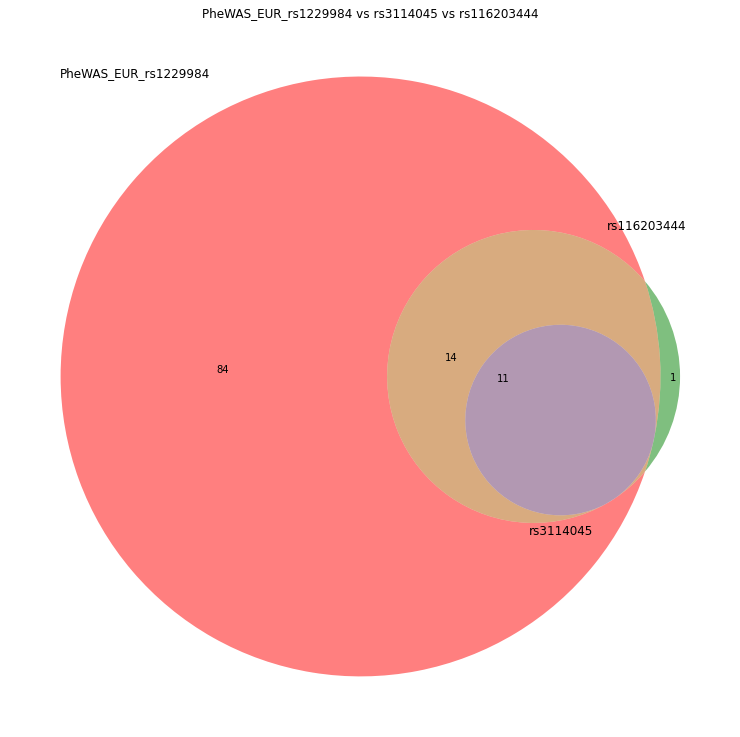

In [194]:
f = plt.figure(figsize= (15,13))
v3 = venn3([set(eur_sig['phenotype']),set(rs44_sig['phenotype']),set(rs45_sig['phenotype'])], set_labels = ('PheWAS_EUR_rs1229984','rs116203444', 'rs3114045'), alpha = 0.5);
plt.title('PheWAS_EUR_rs1229984 vs rs3114045 vs rs116203444')

f.savefig('no_anno_PheWAS_EUR_rs1229984_vs_rs3114045_vs_rs116203444.png',bbox_inches = 'tight')


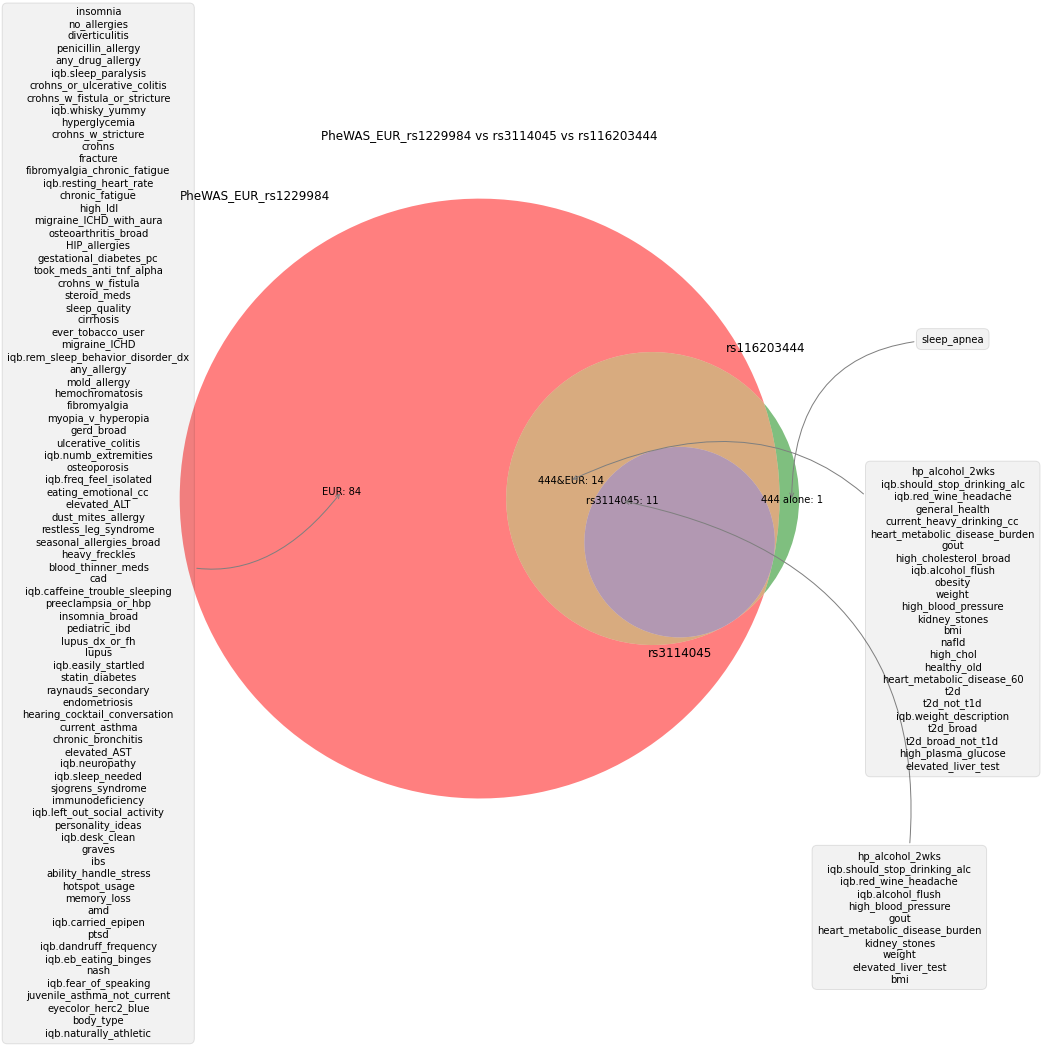

In [163]:
# PheWAS_EUR_rs1229984 vs rs3114045 vs rs116203444
f = plt.figure(figsize= (15,13))
v3 = venn3([set(eur_sig['phenotype']),set(rs44_sig['phenotype']),set(rs45_sig['phenotype'])], set_labels = ('PheWAS_EUR_rs1229984','rs116203444', 'rs3114045'), alpha = 0.5);
rs45_rs44ls = '\n'.join(rs45_rs44['phenotype'].values)
eur_rs44ls = '\n'.join(eur_rs44['phenotype'].values)
rs44ls = '\n'.join(rs44['phenotype'].values)
eurls = '\n'.join(eur['phenotype'].values)
v3.get_label_by_id('11').set_text('444&EUR: 14')
v3.get_label_by_id('111').set_text('rs3114045: 11')
v3.get_label_by_id('10').set_text('EUR: 84')
v3.get_label_by_id('01').set_text('444 alone: 1')


plt.annotate(rs45_rs44ls,xy=v3.get_label_by_id('111').get_position(),xytext = (.7,-.9),ha='center',  bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate(eur_rs44ls,xy=v3.get_label_by_id('11').get_position(),xytext = (.8,-.5),ha='center',  bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate(rs44ls,xy=v3.get_label_by_id('01').get_position(),xytext = (.8,0.3),ha='center',  bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate(eurls,xy=v3.get_label_by_id('10').get_position(),xytext = (-.8,-1),ha='center',  bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.title('PheWAS_EUR_rs1229984 vs rs3114045 vs rs116203444')

f.savefig('PheWAS_EUR_rs1229984_vs_rs3114045_vs_rs116203444.png',bbox_inches = 'tight')


In [153]:
rs84L = pd.read_excel('PheWAS_only_sig.xlsx', 'rs1229984_L')
rs45L = pd.read_excel('PheWAS_only_sig.xlsx', 'rs3114045_L')
rs44L = pd.read_excel('PheWAS_only_sig.xlsx', 'rs116203444_L')

In [155]:
bon = 0.05/rs84L.shape[0]
rs84L_sig = rs84L[rs84L['pvalue'] < bon]
bon = 0.05/rs45L.shape[0]
rs45L_sig = rs45L[rs45L['pvalue'] < bon]
bon = 0.05/rs44L.shape[0]
rs44L_sig = rs44L[rs44L['pvalue'] < bon]

In [184]:
rs45L_notrs44L = rs45L_sig[~rs45L_sig['phenotype'].isin(rs44L_sig['phenotype'])]
rs45L_rs44L = rs45L_sig[rs45L_sig['phenotype'].isin(rs44L_sig['phenotype'])]
rs44L_notrs45L = rs44L_sig[~rs44L_sig['phenotype'].isin(rs45L_sig['phenotype'])]


In [175]:
rs45L_notrs44L

,variant,category,phenotype,pvalue,pvalue_GC_adj,effect,stderr,effective_size
1,rs3114045,cardiovascular,high_blood_pressure,4.796558e-08,0.000002,-0.041072,0.007534,70415.2
3,rs3114045,longevity,heart_metabolic_disease_burden,2.356069e-05,0.001605,-0.009624,0.002276,417655.0
4,rs3114045,metabolic,bmi_qnorm,3.910219e-05,0.048354,-0.010151,0.002468,440284.0


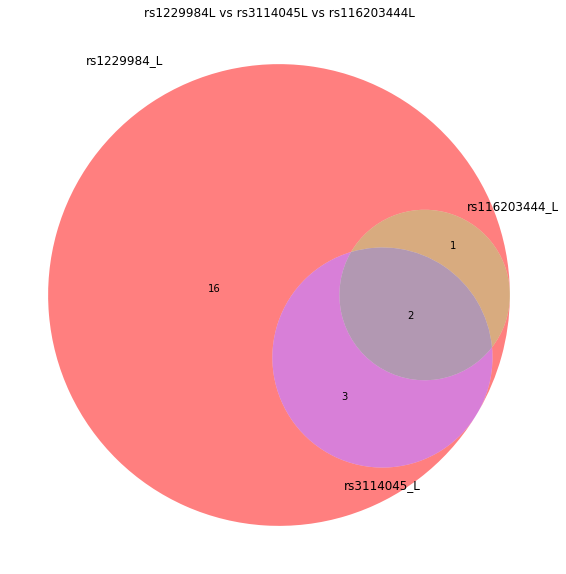

In [196]:
f = plt.figure(figsize= (10,10))
v3 = venn3([set(rs84L_sig['phenotype']),set(rs44L_sig['phenotype']),set(rs45L_sig['phenotype'])], set_labels = ('rs1229984_L', 'rs116203444_L', 'rs3114045_L'), alpha = 0.5);
plt.title('rs1229984L vs rs3114045L vs rs116203444L')

f.savefig('no_anno_rs1229984_L_vs_rs3114045L_vs_rs116203444L.png',bbox_inches = 'tight')

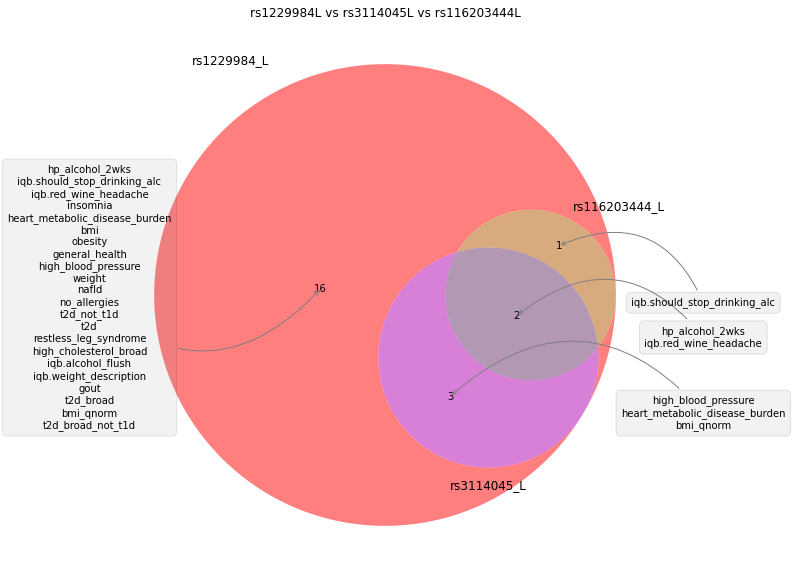

In [189]:
f = plt.figure(figsize= (10,10))
v3 = venn3([set(rs84L_sig['phenotype']),set(rs44L_sig['phenotype']),set(rs45L_sig['phenotype'])], set_labels = ('rs1229984_L', 'rs116203444_L', 'rs3114045_L'), alpha = 0.5);
rs84Lls = '\n'.join(rs84L_sig['phenotype'].values)
rs45L_notrs44Lls = '\n'.join(rs45L_notrs44L['phenotype'].values)
rs45L_rs44Lls = '\n'.join(rs45L_rs44L['phenotype'].values)
rs44L_notrs45Lls = '\n'.join(rs44L_notrs45L['phenotype'].values)
plt.annotate(rs84Lls,xy=v3.get_label_by_id('10').get_position(),xytext = (-.8,-.3),ha='center',  bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate(rs45L_notrs44Lls,xy=v3.get_label_by_id('101').get_position(),xytext = (.7,-.3),ha='center',  bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate(rs45L_rs44Lls,xy=v3.get_label_by_id('111').get_position(),xytext = (.7,-.1),ha='center',  bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate(rs44L_notrs45Lls,xy=v3.get_label_by_id('110').get_position(),xytext = (.7,0),ha='center',  bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.title('rs1229984L vs rs3114045L vs rs116203444L')

f.savefig('rs1229984_L_vs_rs3114045L_vs_rs116203444L.png',bbox_inches = 'tight')


In [192]:
import venn


ModuleNotFoundError: No module named 'venn'